In [81]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.stattools import adfuller
import scipy.stats

In [82]:
stats = pd.read_csv('stats.csv')
stats.columns

Index(['date', 'business', 'category', 'item_description', 'document',
       'document_ID', 'client_name', 'packaging', 'unit_cost', 'sold_quantity',
       'total_cost', 'unit_price', 'total_sale_price', 'delivery_price',
       'gross_profit', 'total_taxes', 'total_tax_retention', 'current_balance',
       'amount_paid', 'payment_dates', 'gross_profit_percentage', 'address',
       'client_ID', 'item_ID', 'year_extracted', 'month_extracted',
       'day_extracted'],
      dtype='object')

In [83]:
def time_series_plot(df):
    # This functions is use to create the time series from each item that is been sold
    # what is doing is that grab the actual day of the register and concatenating the
    # year and week putting x-axis = Week of the Year and y-axis = the added quantity sold per week per year
    df['date'] = pd.to_datetime(df['date'])
    df = df[df['item_description'] == 'Botella_750ml']
    
    df = df[['year_extracted','date', 'item_description','unit_cost','unit_price', 'sold_quantity']]
    df['year_week'] = df['date'].dt.strftime('%Y-%U')
    df_summed = df.groupby(['year_week','item_description']).agg({'unit_cost': 'mean', 'sold_quantity': 'sum', 'unit_price': 'mean'})
    df_summed = df_summed.reset_index()

    n = len(pd.unique(df_summed['item_description']))
    item_description = pd.unique(df_summed['item_description'])

    print(df_summed.shape)

    fig, axs = plt.subplots(nrows=n, ncols=1, figsize=(30, 5 * n), dpi=80)
    plt.subplots_adjust(hspace=0.5)
    fig.suptitle("Amount of quantities sold per week", fontsize=18, y=0.1)
    
    if n == 1:  
        axs = [axs]

    for idx, item in enumerate(item_description):
        item_data = df_summed[df_summed['item_description'] == item]
        ax = axs[idx]
        ax.plot(item_data['year_week'], item_data['unit_cost'], marker='o')
        ax.plot(item_data['year_week'], item_data['unit_price'], marker='o')
        ax.plot(item_data['year_week'], item_data['sold_quantity'], marker='o')
        ax.set_title(item.upper())
        ax.set_xlabel("Year Week")
        ax.set_xticklabels(item_data['year_week'], rotation=45)
        ax.set_ylabel("Quantities that has been sold")
        
        ax.grid(True)

    plt.show()

(146, 5)


C:\Users\andre\AppData\Local\Temp\ipykernel_23052\3440315012.py:33: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(item_data['year_week'], rotation=45)


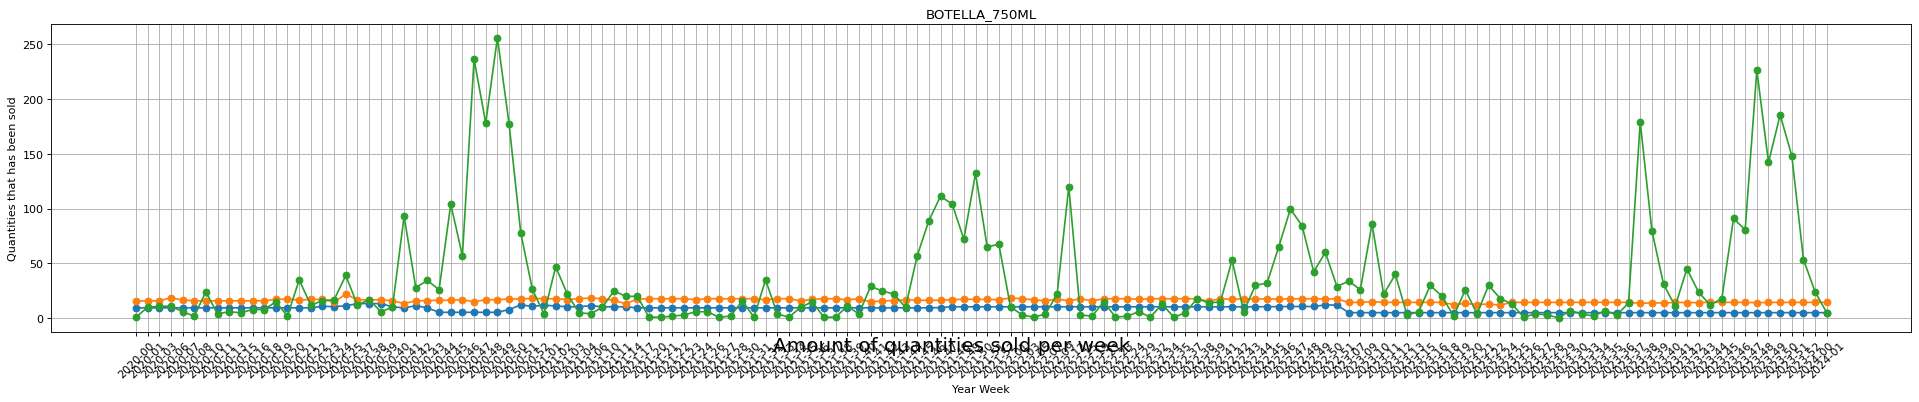

In [84]:
time_series_plot(stats)

In [85]:
def distribution_plot(df):

    df['date'] = pd.to_datetime(df['date'])
    df = df[df['item_description'] == 'Botella_750ml']
    
    df = df[['year_extracted','date', 'item_description','unit_cost','unit_price', 'sold_quantity']]
    df['year_week'] = df['date'].dt.strftime('%Y-%U')
    df_summed = df.groupby(['year_week','item_description']).agg({'unit_cost': 'mean', 'sold_quantity': 'sum', 'unit_price': 'mean'})
    df_summed = df_summed.reset_index()

    n = len(pd.unique(df_summed['item_description']))
    item_description = pd.unique(df_summed['item_description'])

    print(df_summed.shape)

    fig, axs = plt.subplots(nrows=n, ncols=1, figsize=(30, 5 * n), dpi=80)
    plt.subplots_adjust(hspace=0.5)
    fig.suptitle("Amount of quantities sold per week", fontsize=18, y=0.1)
    
    if n == 1:  
        axs = [axs]

    for idx, item in enumerate(item_description):
        item_data = df_summed[df_summed['item_description'] == item]
        ax = axs[idx]
        sns.histplot(item_data['sold_quantity'], kde=True, ax=ax)
        sns.histplot(item_data['unit_cost'], kde=True, ax=ax)
        ax.set_title(item.upper())
        ax.set_xlabel("Quantities that has been sold")
        ax.set_ylabel("Frequency")
        ax.grid(True)

    plt.show()

(146, 5)


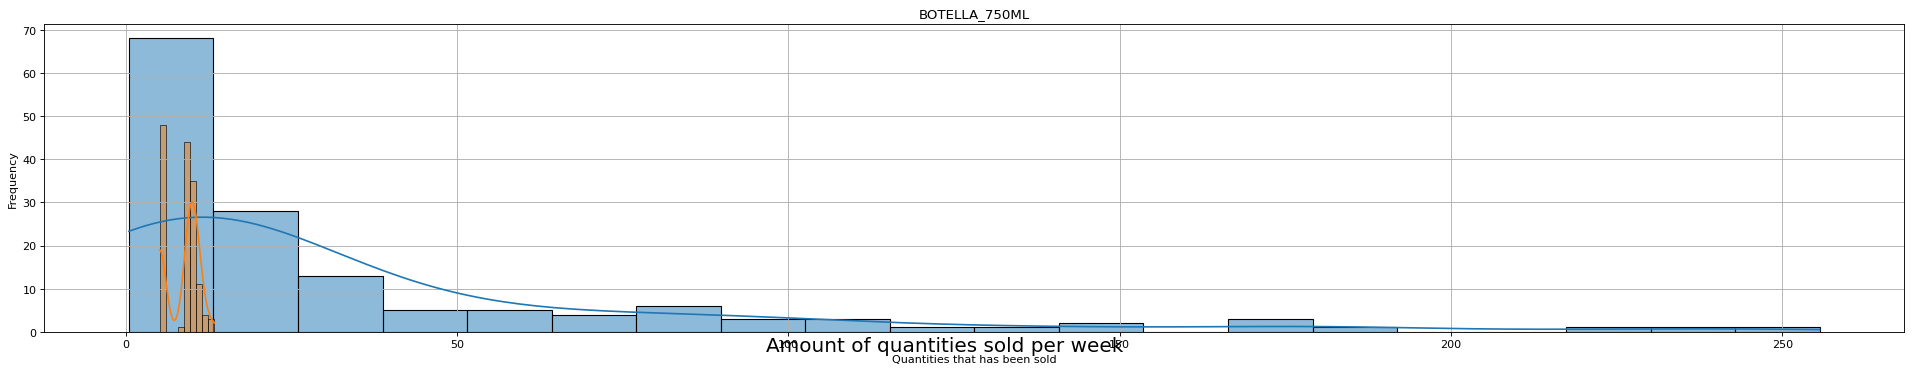

In [86]:
distribution_plot(stats)